<a href="https://colab.research.google.com/github/evgeny-kolonsky/timetable_validity/blob/main/Timetable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate groups and calculate rating

v.0.3.1

Physics Dept 2023/2024: [Catalogue](https://ugportal.technion.ac.il/wp-content/uploads/2024/02/11-%D7%A4%D7%99%D7%96%D7%99%D7%A7%D7%94-%D7%AA%D7%A9%D7%A4%D7%B4%D7%93.pdf)

In [123]:
import requests
import json
import numpy as np
import pandas as pd
import itertools

# Import from json

Full catalogue of courses loaded from SAP with [fetcher](https://github.com/michael-maltsev/technion-sap-info-fetcher) written by Michael Maltsev.

In [124]:
# full catalogue of courses fetched from SAP
# semester 2024_201 (winter 24/25)
# source code: https://github.com/michael-maltsev/technion-sap-info-fetcher
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/timetable_validity/main/2024_201.json'
response = requests.get(url)
catalogue = json.loads(response.text)
print(f'Loaded {len(catalogue)} courses')

Loaded 1058 courses


# Import from xlsx

Excel file exported from SAP Miscal user interface by Larisa Koloskova.

In [125]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/timetable_validity/main/2024_201.XLSX'
df = pd.read_excel(url)

In [126]:
courses_df = df['מקצוע'].unique()

excluded_groups = ['77',  'SE077']


catalogue = [] # from dataframe to json

# loop over courses
for course_id in courses_df:

  #if course_id != 1040034:
  #  continue

  course = {}
  course['general'] = {}
  course['general']['מספר מקצוע'] = f'{course_id:08d}'
  course['schedule'] = []


  filter = df['מקצוע'] == course_id
  this_course = df[filter]
  groups = this_course['תיאור חבילת רישום'].unique()

  # loop over groups
  for group_id in groups:

    # Get rid of groups having names with prohibited substrings, like 77 - group for Chinese
    if any(x in str(group_id) for x in excluded_groups):
      continue


    filter2 = this_course['תיאור חבילת רישום'] == group_id
    this_group = this_course[filter2]

    # loop over slots
    for index, event in this_group.iterrows():
      slot = {}
      group_type = event['סוג אירוע D']

      group_capacity = event['קיבולת חבילת רישום']
      if group_capacity == 0: # skip
        continue

      # loop over columns to choose non-empty slot
      for group_day in ['ראשון','שני','שלישי','רביעי','חמישי']:
        group_hour = event[group_day]
        if not pd.isna(group_hour):
          slot['סוג'] = group_type
          slot['קבוצה'] = group_id.split()[0]
          slot['שעה'] = group_hour
          slot['יום'] = group_day
          course['schedule'].append(slot)
          #print(course_id, slot)
          break

  catalogue.append(course)

print(f'Loaded {len(catalogue)} courses')


Loaded 1225 courses


# Default hourmap rules

- Technion:
  - Sunday 08:30 do not use
  - Wednesday 12:30 and 13:30 do not use
- Physics:
  - Monday 14:30 do not use
  - (?) Thursday 14:30 till end of the day do not use  - not applied


In [127]:
# function to make hoursmap as 2d np array days x hours
# we read day and hours out of text description in timeslot
# suggested that all timeslots start and xx:30, between 08:30 and 19:30,
# which is not quite so for all published courses (sports may be exception)

WEEK = ['ראשון','שני','שלישי','רביעי','חמישי']
SLOTS = [f'{h:02d}:30' for  h in range(8, 19)] # 1 hour slots

def EMPTY_MAP():
  return np.zeros((len(WEEK), len(SLOTS)), dtype=int)

# Hour map with prohibited slots
def DEFAULT_MAP():
  hours_map = EMPTY_MAP()

  # Technion rules
  # 1. Sunday 08:30 do not use
  hours_from_ind, hours_to_ind = SLOTS.index('08:30'), SLOTS.index('09:30')
  days_ind = 0 # Sunday
  hours_map[days_ind, hours_from_ind:hours_to_ind] = 1

  # 2. Wednesday 12:30 and 13:30 do not use
  hours_from_ind, hours_to_ind = SLOTS.index('12:30'), SLOTS.index('14:30')
  days_ind = 3 # Wendesday
  hours_map[days_ind, hours_from_ind:hours_to_ind] = 1

  # Physics rules
  # 3. Monday 14:30 do not use
  hours_from_ind, hours_to_ind = SLOTS.index('14:30'), SLOTS.index('15:30')
  days_ind = 1 # Monday
  hours_map[days_ind, hours_from_ind:hours_to_ind] = 1

  # 4. Thursday 14:30 till end of the day do not use
  #hours_from_ind = SLOTS.index('14:30')
  #days_ind = 4 # Thursday
  #hours_map[days_ind, hours_from_ind:-1] = 1

  return hours_map


def parse_slot(slot, course_id):
  group_type = slot['סוג']
  group_number = slot['קבוצה']
  group_hour = slot['שעה']
  group_day = slot['יום']
  hours_map = EMPTY_MAP()
  hours_from, hours_to = group_hour.replace(' ', '').split('-')
  if hours_from not in SLOTS or hours_to not in SLOTS:
    # error message: irregular hours
    print(f'WARNING! {course_id} irregular hours: {slot}')
    return 0
  hours_from_ind, hours_to_ind = SLOTS.index(hours_from), SLOTS.index(hours_to)
  days_ind = WEEK.index(group_day)
  hours_map[days_ind, hours_from_ind:hours_to_ind] = 1
  return hours_map

# Ratings

Each given combination produces hourmap matrix. This matrix is used to calculate metrics: rating and score.

**Rating** is counted as a count of all possible combinations in basic courses, allowing student to choose the group in laboratory cours.

Non-feasible hourmap returns zero rating.

**Score** is counted as averaged schedule density, calculated as a ratio: `hours_in_class` / `total_time_spent_in_campus`
so that schedule with many-hours break between classes receive low score, while schedule with tight classes receive higher score.




In [138]:
def hours_in_campus(hourmap):
  ans = np.zeros(len(WEEK))

  for i in range(len(WEEK)):
    day = hourmap[i, :]
    nz = np.nonzero(day)[0]
    if nz.size > 0:
      start = np.min(nz)
      end = np.max(nz)
      total_hours = end - start + 1
      work_hours = np.sum(day)
    else:
      total_hours, work_hours = 0, 0
    ans[i] = total_hours
    #print(f'{i}: {work_hours} out of {total_hours}')
  #print(hourmap)
  return ans

def score_hourmap(hourmap):
    classes_hourmap = hourmap - DEFAULT_MAP()
    hic = hours_in_campus(classes_hourmap) # array of hours in campus for each day
    total_hic_week = np.sum(hic) # total hours in campus for a week
    workload = np.sum(classes_hourmap) # total learning hours: lectures, practice and labs
    return hic, total_hic_week, workload

def rate_hourmap(check):

  if np.sum(check > 1) > 0: # overload, not feasible
    return 0
  else: # feasible, rating 1 by default
    return 1



In [143]:
# here is the cell  where all possible combination of groups for each activity are created
# and checked against feasibility by aggregating their hour maps
# feasible combination has only ones and zeroes in aggregated hours map
# Two and more means activities overlapping



def find_feasible_groups(basic_courses_ids,  lab_course_id):

  not_found = [x for x in basic_courses_ids if x not in  [course['general']['מספר מקצוע'] for course in catalogue]]
  if len(not_found) > 0:
    print('WARNING! Courses not found in catalogue:', not_found)

  basic_courses = [course for course in catalogue if course['general']['מספר מקצוע'] in basic_courses_ids]

  # Read schedule from catalogue and fill hourmaps for basic courses
  activity = {}
  for course in basic_courses:
    course_id = course['general']['מספר מקצוע']

    activity[course_id] = {}
    slots = course['schedule']
    for slot in slots:
      group_id = str(slot['קבוצה'])

      activity[course_id][group_id] = \
        activity[course_id].get(group_id, EMPTY_MAP()) + parse_slot(slot, course_id)

  # Generate synthetic hourmaps for lab course
  activity[lab_course_id] = {}
  for day in range(len(WEEK)):
    for hour in [0,1, 3,4, 6,7]:
      hourmap = EMPTY_MAP()
      hourmap[day,hour:hour+3] = 1
      slotname = f'{day+1}.{SLOTS[hour][:3]}'
      #print(f'{slotname}\n {hourmap}')
      activity[lab_course_id][slotname] = hourmap

  # Generate all possible combinations of basic courses and lab course
  # and for each combination test it's feasibility

  combins = [
              [f'{course}_{group}' for group in activity[course]]
              for course in activity.keys()
          ]

  rating = {} # group rating counter
  score = {} # group rating score
  text = '' # miltiline text to save all feasible combination
  text += ', '.join(activity.keys()) +', hours_in_campus, total, workload, score \n' # header

  #print('Feasible combinations:')
  for combination in itertools.product(*combins):
      # init hourmap with default slots
      check = DEFAULT_MAP()

      # integrate hourmap for current combination of groups
      for group in combination:
        # extract course and group ids from element in combinations
        course_id, slot_id = group.split('_')
        # aggregate hours for groups in combination
        check += activity[course_id][slot_id]
        # init counter if met 1st time
        if course_id == lab_course_id:
          rating[slot_id] = rating.get(slot_id, 0)
          score[slot_id] = score.get(slot_id, 0)

      # check aggregated hourmap against overload criterion
      if np.sum(check > 1) > 0: # overload, not feasible
        continue
      else:  # feasible

        # aggregate rating counter
        hic, total_hic_week, workload = score_hourmap(check)
        text += f'{combination}, {hic}, {total_hic_week}, {workload}, {workload/total_hic_week:.2f}\n'
        for group in combination:
          course_id, slot_id = group.split('_')
          if course_id == lab_course_id:
                rating[slot_id] += rate_hourmap(check)
                score[slot_id] += workload / total_hic_week

  # Normalize score
  for x in rating:
    if rating[x] != 0:
      score[x] /= rating[x]

  return rating, score, text



# Semester 1

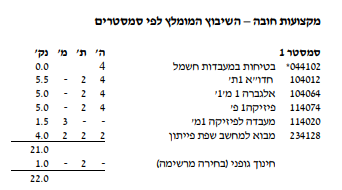

In [147]:
semester = ['01040012', '01040064', '01140074','02340128']
rating, score, text = find_feasible_groups(semester, lab_course_id='114020')

for key, value in rating.items():
    print(f'{key}, {rating[key]:6d}, {score[key]:6.2f}')

with open('combinations.csv', 'w') as f:
    f.write(text)

1.08:,      0,   0.00
1.09:,     30,   0.85
1.11:,     43,   0.86
1.12:,     21,   0.82
1.14:,      0,   0.00
1.15:,      0,   0.00
2.08:,     45,   0.82
2.09:,     45,   0.84
2.11:,      8,   0.87
2.12:,      0,   0.00
2.14:,      0,   0.00
2.15:,     48,   0.85
3.08:,      0,   0.00
3.09:,      0,   0.00
3.11:,      0,   0.00
3.12:,      0,   0.00
3.14:,     57,   0.83
3.15:,     77,   0.82
4.08:,     38,   0.76
4.09:,     38,   0.78
4.11:,      0,   0.00
4.12:,      0,   0.00
4.14:,     27,   0.85
4.15:,     27,   0.83
5.08:,      0,   0.00
5.09:,      0,   0.00
5.11:,      0,   0.00
5.12:,     27,   0.87
5.14:,    103,   0.82
5.15:,    103,   0.80


# Semester 2

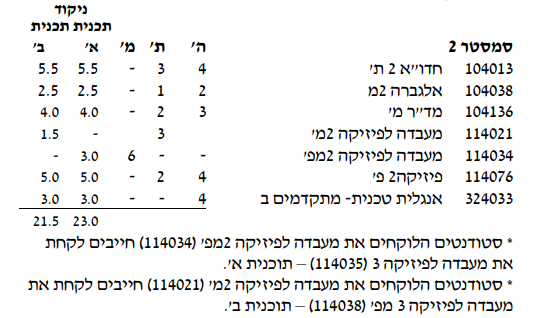

In [149]:
semester = ['01040013', '01040038', '01040136','01140076'] # 01140076 noy found in catalogue

rating, score, text = find_feasible_groups(semester, lab_course_id='114021')

for key, value in rating.items():
    print(f'{key}, {rating[key]:6d}, {score[key]:6.2f}')

with open('combinations.csv', 'w') as f:
    f.write(text)

WARNING! Courses not found in catalogue: ['01140076']
1.08:,      0,   0.00
1.09:,      4,   0.86
1.11:,      2,   0.86
1.12:,      6,   0.87
1.14:,     10,   0.84
1.15:,     10,   0.81
2.08:,      0,   0.00
2.09:,      0,   0.00
2.11:,      0,   0.00
2.12:,      0,   0.00
2.14:,      0,   0.00
2.15:,     10,   0.83
3.08:,      0,   0.00
3.09:,      0,   0.00
3.11:,      0,   0.00
3.12:,      3,   0.90
3.14:,      5,   0.84
3.15:,     10,   0.82
4.08:,      0,   0.00
4.09:,      0,   0.00
4.11:,      0,   0.00
4.12:,      0,   0.00
4.14:,      0,   0.00
4.15:,      5,   0.84
5.08:,      2,   0.86
5.09:,      4,   0.88
5.11:,      4,   0.84
5.12:,     10,   0.84
5.14:,     10,   0.79
5.15:,     10,   0.76


# Semester 3

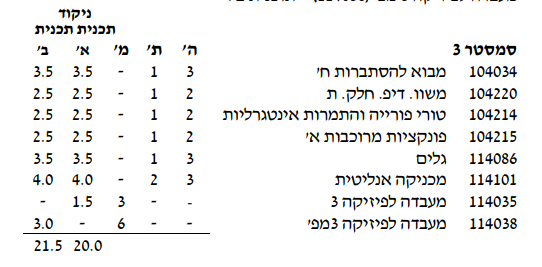

In [151]:
semester = ['01040034', '01040220', '01040214','01040215','01140086','01140101']

rating, score, text = find_feasible_groups(semester, lab_course_id='114035')

for key, value in rating.items():
    print(f'{key}, {rating[key]:6d}, {score[key]:6.2f}')

with open('combinations.csv', 'w') as f:
    f.write(text)

1.08:,      0,   0.00
1.09:,      0,   0.00
1.11:,     39,   0.81
1.12:,     66,   0.80
1.14:,    204,   0.79
1.15:,    306,   0.77
2.08:,      0,   0.00
2.09:,      0,   0.00
2.11:,      0,   0.00
2.12:,      0,   0.00
2.14:,      0,   0.00
2.15:,    105,   0.80
3.08:,    192,   0.76
3.09:,    192,   0.78
3.11:,     99,   0.81
3.12:,     84,   0.80
3.14:,     60,   0.80
3.15:,    132,   0.82
4.08:,      0,   0.00
4.09:,      0,   0.00
4.11:,      0,   0.00
4.12:,      0,   0.00
4.14:,     54,   0.83
4.15:,     36,   0.82
5.08:,      0,   0.00
5.09:,      0,   0.00
5.11:,      0,   0.00
5.12:,      0,   0.00
5.14:,    306,   0.79
5.15:,    306,   0.76


# Joined tracks


## 114034 Physics

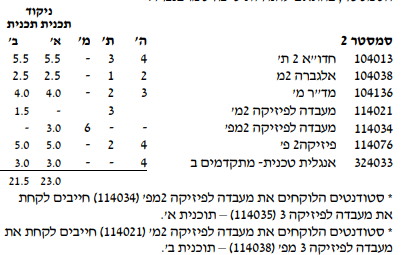

## 114030 Physics + Electroengineering


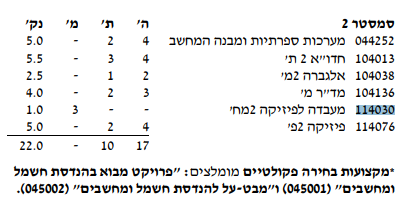

## 114021 Physics + Mathematics

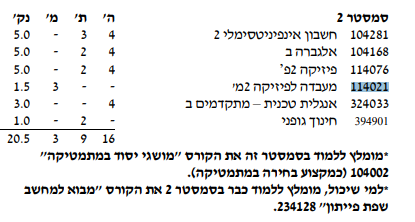

In [152]:
tracks = {}
tracks['114034'] = ['01040013', '01040038','01040136', '01040076'] # Physics
tracks['114030'] = ['00440252', '01040013', '01040038','01040136', '01040076'] # Physics + Electro
tracks['114021'] = ['01040281','01040168', '01040076'] # Physics + Math

ratings = {}
scores = {}
for lab_course_id in tracks.keys():
  ratings[lab_course_id], scores[lab_course_id], _ = find_feasible_groups(tracks[lab_course_id], lab_course_id)

WARNING! Courses not found in catalogue: ['01040076']
WARNING! Courses not found in catalogue: ['01040076']
WARNING! 00440252 irregular hours: {'סוג': 'הרצאה', 'קבוצה': 'SE021', 'שעה': '15:30-19:30', 'יום': 'שלישי'}
WARNING! 00440252 irregular hours: {'סוג': 'הרצאה', 'קבוצה': 'SE022', 'שעה': '15:30-19:30', 'יום': 'שלישי'}
WARNING! 00440252 irregular hours: {'סוג': 'הרצאה', 'קבוצה': 'SE023', 'שעה': '15:30-19:30', 'יום': 'שלישי'}
WARNING! 00440252 irregular hours: {'סוג': 'הרצאה', 'קבוצה': 'SE024', 'שעה': '15:30-19:30', 'יום': 'שלישי'}
WARNING! Courses not found in catalogue: ['01040076']


In [153]:
ratings_pd = pd.DataFrame(ratings)
ratings_pd

,114034,114030,114021
1.08:,0,0,0
1.09:,4,4,1
1.11:,2,2,0
1.12:,6,8,0
1.14:,10,6,0
1.15:,10,6,0
2.08:,0,0,1
2.09:,0,0,1
2.11:,0,0,0
2.12:,0,0,0


In [154]:
scores_pd = pd.DataFrame(scores)
scores_pd

,114034,114030,114021
1.08:,0.000000,0.000000,0.000000
1.09:,0.858117,0.855965,0.882353
1.11:,0.857143,0.869565,0.000000
1.12:,0.872078,0.880721,0.000000
1.14:,0.835519,0.834727,0.000000
1.15:,0.806161,0.813312,0.000000
2.08:,0.000000,0.000000,0.833333
2.09:,0.000000,0.000000,0.882353
2.11:,0.000000,0.000000,0.000000
2.12:,0.000000,0.000000,0.000000
